<table style="width: 100%;">
  <tr>
    <td style="text-align: left;"><h1 style="font-size: 30px;">K Nearest Neighbours</h1></td>
    <td style="text-align: right;"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Logo_Universitat_de_Barcelona.png" alt="University of Barcelona Logo" width="200" /></td>
  </tr>
</table>

## Model making

### Imports

In [4]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
from tqdm import tqdm_notebook as tqdm #Visualising exectuion progress

#for printing preatty
from markdown import markdown
from IPython.display import Markdown, HTML
from rich import print

# Eliminate warnings for presentation purpuses
import warnings
warnings.filterwarnings('ignore') #ignore all warnings, very messy
#warnings.filterwarnings('default')
pd.options.mode.chained_assignment = None


#To be able to show matplotlib graphs and results in this JupyterNotebook
get_ipython().run_line_magic('matplotlib', 'inline')


In [5]:
# Load the database using the second row as the name of the features
df=pd.read_excel(r'credit_cards.xls',engine='xlrd',header=1)

In [6]:
print(f"This is a snippet of the database being used")
display(df.head())

This is a snippet of the database being used

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,roc_auc_score,confusion_matrix, recall_score,f1_score,brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from hmeasure import h_score


### Model

In [8]:
# dividing the data
X=df.drop('default payment next month',axis=1)    # Input values
y=df['default payment next month']                # Results
scaler=StandardScaler()

In [9]:
kn=KNeighborsClassifier(n_neighbors=10,metric='euclidean')
# Calibrate the model
c_kn = CalibratedClassifierCV(kn, method='isotonic', cv=3)
sm=SMOTE(random_state=101)

In [10]:
# --------------------------------------------------------

# FIT THE MODEL AND EXTRACT NEW RESULTS

# --------------------------------------------------------
def get_scores(model,X_train, X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_pred1=model.predict_proba(X_test)
    
    accuracy=accuracy_score(y_test,y_pred).round(2)
    auroc=roc_auc_score(y_test,y_pred)
    conf=confusion_matrix(y_test,y_pred)
    precision=precision_score(y_test,y_pred,pos_label=0)
    recall=recall_score(y_test,y_pred,pos_label=0)
    h=h_score(np.array(y_test),y_pred,pos_label=0)
    f1=f1_score(y_test,y_pred,pos_label=0)
    bs=brier_score_loss(y_test,y_pred1[:,0],pos_label=0)
    
    return accuracy,auroc,conf,precision,recall,f1,h,bs

In [11]:
# --------------------------------------------------------

# TRAIN THE MODEL AND EXTRACT RESULTS

# --------------------------------------------------------
def train_new_model(model,X,y):
    # kNN sccore lists
    kn_accuracy, kn_auroc, kn_precision, kn_recall, kn_f1, kn_h, kn_bs = [[] for _ in range(7)]
    kn_conf=np.zeros([2,2])

    kfolds=10
    skf=StratifiedKFold(n_splits=kfolds)

    for train_index, test_index in tqdm(skf.split(X, y)):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaled_X_train=scaler.fit_transform(X_train)
        scaled_X_test=scaler.transform(X_test)
        X_resamp,y_resamp=sm.fit_resample(scaled_X_train,y_train)
        
        # update kNN Scores
        new_results = get_scores(model,X_resamp, scaled_X_test,y_resamp,y_test)
        kn_accuracy.append(new_results[0])
        kn_auroc.append(new_results[1])
        kn_conf+=new_results[2]
        kn_precision.append(new_results[3])
        kn_recall.append(new_results[4])
        kn_f1.append(new_results[5])
        kn_h.append(new_results[6])
        kn_bs.append(new_results[7])

    print("Models fitted")
    
    dict_results = {"kn_accuracy":kn_accuracy,"kn_auroc":kn_auroc, "kn_conf":kn_conf, "kn_precision":kn_precision,
                   "kn_recall":kn_recall, "kn_f1":kn_f1,"kn_h":kn_h,"kn_bs":kn_bs, "kfolds":kfolds}
    
    return model, dict_results

In [12]:
# --------------------------------------------------------

# THESE FUNCTIONS WILL HELP US SAVE AND LOAD MODELS AND RESULTS

# --------------------------------------------------------
import pickle
import os
import json
        
def save_results(data,name = "results_full_knn", algo = 'KNN'):
    
    # Check if the directorys exist, if not, create them
    directory = fr'models/{algo}'
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, fr'{name}.json')
    
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(data, pickle_file)
        
def load_results(name = "results_full_knn", algo = 'KNN'):
    doc_name = fr'models/{algo}/{name}.json'
    with open(doc_name, 'rb') as pickle_file:
        results = pickle.load(pickle_file)
    return results

def save_model(model,name = "full_knn", algo = "KNN"):
    
    # Check if the directorys exist, if not, create them
    directory = fr'models/{algo}'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    file_path = os.path.join(directory, fr'{name}.json')
        
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)
    print(f'----------------------------Model Saved (Path: {file_path})-----------------------------')
    
def load_model(name = "full_knn", algo = "KNN"):
    doc_name = fr'models/{algo}/{name}.pkl'
    print("-----------------------------Model Found----------------------------------------")
    with open(doc_name, 'rb') as file:
        model = pickle.load(file)
    print(f'----------------------------Model Loaded (Path: {doc_name})-----------------------------')
    return model
        
        
def train_model(model, X, y, name = 'full_knn', algo = "KNN", recalculate = False):
    doc_name = fr'models/{algo}/{name}.pkl'
    # Check if the document exists in the folder
    if os.path.exists(doc_name) & (not recalculate):
        model = load_model(name,algo)
        dict_results = load_results(f"results_{name}",algo)
    else:
        print(f'----------------------------Model Not Found (Path: {doc_name})-----------------------------')
        print("Lets train the model!!")
        model, dict_results = train_new_model(model,X,y) 
        print('----------------------------Model Trained-----------------------------')
        save_model(model,name,algo)
        save_results(dict_results,f"results_{name}",algo)
        
    return model, dict_results

In [13]:
X_2 = X.iloc[:, 1:]
display(X_2.head(4))

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000


In [15]:
name = 'full_knn'
algo = 'KNN'
recalculate = False
c_kn, dict_results = train_model(c_kn,X,y, name, algo, recalculate)
display(c_kn)

-----------------------------Model Found----------------------------------------

----------------------------Model Loaded (Path: models/KNN/full_knn.pkl)-----------------------------

CalibratedClassifierCV(cv=3,
                       estimator=KNeighborsClassifier(metric='euclidean',
                                                      n_neighbors=10),
                       method='isotonic')

### Predictive performance tests

In [16]:
kn_accuracy = dict_results["kn_accuracy"]
kn_auroc = dict_results["kn_auroc"]
kn_precision = dict_results["kn_precision"]
kn_recall = dict_results["kn_recall"]
kn_f1 = dict_results["kn_f1"]
kn_conf = dict_results["kn_conf"]
kn_h = dict_results["kn_h"]
kn_bs = dict_results["kn_bs"]
#kfolds = dict_results["kfolds"]
kfolds = 10

In [17]:
# Overall scores kNN
mkn_accuracy=(np.array(kn_accuracy)).mean()
mkn_auroc=(np.array(kn_auroc)).mean()
mkn_precision=(np.array(kn_precision)).mean()
mkn_recall=(np.array(kn_recall)).mean()
mkn_f1=(np.array(kn_f1)).mean()
mkn_conf=(kn_conf/kfolds).round()
mkn_h=(np.array(kn_h)).mean()
mkn_bs=(np.array(kn_bs)).mean()

In [18]:
#Brier Skill Score
bss=(1-(mkn_bs/1)).round(3)
#print(f'The Bruer Skill Score is {bss}')

s = f"""
<center>
**Predictive Performance tests results**
<center>
<center>

| Model  | Accuracy | AUROC | Precision | Recall | F1 | H-measure | Brier Score | Brier Skill Score |
| ------------- | -------------| -------------| -------------| -------------| -------------| -------------| -------------| -------------|
| KNN   |  {mkn_accuracy:.3f} |  {mkn_auroc:.3f} |  {mkn_precision:.3f} |  {mkn_recall:.3f} |  {mkn_f1:.3f} |  {mkn_h:.3f} |  {mkn_bs:.3f} |  {bss:.3f} |

</center>
"""
html = markdown(s, extensions=["tables"])
display(HTML(html))

Model,Accuracy,AUROC,Precision,Recall,F1,H-measure,Brier Score,Brier Skill Score
KNN,0.754,0.658,0.851,0.831,0.840,0.000,0.182,0.818


In [19]:
#print(mkn_conf)

s = f"""
<center>
**KNN Confusion Matrices**
<center>
<center>

|    | Yes | No |
| ------------- | -------------| -------------| 
| Yes   |  {mkn_conf[0][0]} |  {mkn_conf[0][1]} |
| No   |  {mkn_conf[1][0]} |  {mkn_conf[1][1]} |

</center>
"""

print(f"Thise are the results of the Confucion Matrix tests:")
html = markdown(s, extensions=["tables"])
display(HTML(html))

Thise are the results of the Confucion Matrix tests:

,Yes,No
Yes,1942.0,395.0
No,342.0,322.0


## Interpretability

### SHAP

#### Calculate SHAP Values

In [20]:
# Provar d'entrenar un model amb només una ronda, a veure si em deixa executar SHAP, sinó, provar algun altre cosa

In [21]:
import shap
from sklearn.model_selection import train_test_split
def SHAP_model_training(model,X,y,name,algo,recalculated = False):
    doc_name = fr'models/{algo}/{name}.json'
    
    if os.path.exists(doc_name) & (not recalculate):
        shap_values = load_results(name,algo)
    else:
        print(f"-----------SHAP values for {algo} not found, START CALCULATION-------------")
        X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=42)   
        scaled_X_train=scaler.fit_transform(X_train)
        scaled_X_train = pd.DataFrame(scaled_X_train,columns = X_train.columns)
        scaled_X_test=scaler.transform(X_test)
        scaled_X_test = pd.DataFrame(scaled_X_train,columns = X_train.columns)
        X_resamp,y_resamp=sm.fit_resample(scaled_X_train,y_train)

        x_sub = shap.sample(X_resamp,100)
        explainer = shap.Explainer(model.predict_proba, x_sub)
        shap_values = explainer(scaled_X_test)
        #shap.plots.beeswarm(shap_values[:,:])

        print("SHAP Values fitted")
        save_results(shap_values,name,algo)
    print(f"-----------SHAP values for {algo} FOUND and LOADED -------------")
    return shap_values

In [22]:
shap_values = SHAP_model_training(c_kn, X, y,"shap_kn","KNN")

-----------SHAP values for KNN FOUND and LOADED -------------

#### Explore SHAP values

In [23]:
print(f"""
-------------------------------------------------------------------------------------------------------------------
The variable shap_values contains an array of 'Explanation' objects ({type(shap_values[0])} of len: {len(shap_values)})
Each SHAP Value Explanation object contains: 

'values'        -> Contains the contribution of each feature to the end result (since we are dealing with a binary classifier, each feature has two partial contributionsc one for each possibility)
'base_values'   -> Contains the average prediction (Since this is a binary classifier, there are two average predictions)
'data'          -> Contains an array of the input features

In both 'values' and 'base_values', the first element always corresponds to the positive scenario and the second to the negative one.
Here is an example of a SHAP value explanation. Also, since we have been able to calculate the explanations for all 6000 test events, we have them all to get a better view of our predictor
-------------------------------------------------------------------------------------------------------------------
""")

display(shap_values[0])
print("""
-------------------------------------------------------------------------------------------------------------------
As we can see in the 'data' of this SHAP Value Explanation object, the values are not undertandable, 
due to the fact that we have standarized them, this will not be a problem since we can use the values 
from the original dataset or even unscale them and we could do it like this: 

    unscaled_X_test = scaler.inverse_transform(scaled_X_test)
-------------------------------------------------------------------------------------------------------------------
""")

-------------------------------------------------------------------------------------------------------------------
The variable shap_values contains an array of 'Explanation' objects (<class 'shap._explanation.Explanation'> of 
len: 6000)
Each SHAP Value Explanation object contains: 

'values'        -> Contains the contribution of each feature to the end result (since we are dealing with a binary 
classifier, each feature has two partial contributionsc one for each possibility)
'base_values'   -> Contains the average prediction (Since this is a binary classifier, there are two average 
predictions)
'data'          -> Contains an array of the input features

In both 'values' and 'base_values', the first element always corresponds to the positive scenario and the second to
the negative one.
Here is an example of a SHAP value explanation. Also, since we have been able to calculate the explanations for all
6000 test events, we have them all to get a better view of our predictor
-------------------------------------------------------------------------------------------------------------------

.values =
array([[ 0.03418597, -0.03418597],
       [-0.03633032,  0.03633032],
       [ 0.00560978, -0.00560978],
       [-0.00593995,  0.00593995],
       [ 0.00444698, -0.00444698],
       [ 0.00743072, -0.00743072],
       [ 0.02527764, -0.02527764],
       [ 0.01852983, -0.01852983],
       [ 0.00464045, -0.00464045],
       [ 0.00399333, -0.00399333],
       [ 0.00765192, -0.00765192],
       [ 0.01563834, -0.01563834],
       [-0.00871094,  0.00871094],
       [-0.01100584,  0.01100584],
       [-0.00382936,  0.00382936],
       [-0.01094443,  0.01094443],
       [-0.02100484,  0.02100484],
       [-0.00202368,  0.00202368],
       [-0.00192334,  0.00192334],
       [-0.00094424,  0.00094424],
       [-0.00164935,  0.00164935],
       [-0.00108512,  0.00108512],
       [-0.00362778,  0.00362778],
       [-0.00084973,  0.00084973]])

.base_values =
array([0.54528929, 0.45471071])

.data =
array([-1.46330554, -1.05776818, -1.23738094,  0.18430622,  0.85811358,
       -1.13637372, 

-------------------------------------------------------------------------------------------------------------------
As we can see in the 'data' of this SHAP Value Explanation object, the values are not undertandable, 
due to the fact that we have standarized them, this will not be a problem since we can use the values 
from the original dataset or even unscale them and we could do it like this: 

    unscaled_X_test = scaler.inverse_transform(scaled_X_test)
-------------------------------------------------------------------------------------------------------------------

In [24]:
h = pd.DataFrame([[i] for i in range(0, len(X_2.columns))]).T
h.columns = X_2.columns
display(h.T)

,0
LIMIT_BAL,0
SEX,1
EDUCATION,2
MARRIAGE,3
AGE,4
PAY_0,5
PAY_2,6
PAY_3,7
PAY_4,8
PAY_5,9


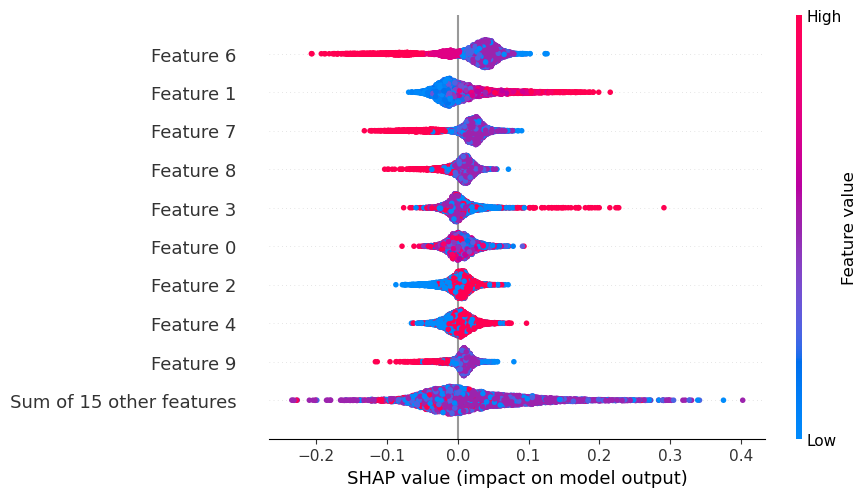

In [25]:
shap.plots.beeswarm(shap_values[:,:,0],max_display=10)

In [355]:
def whaterfall_plot(shap_values,X_test,index = 0,max_display = 10):
    shap_val_0 = shap_values[index, :, 0]
    shap_val_0.data = X_test.iloc[index]
    shap.plots.waterfall(shap_val_0, max_display = max_display)
    shap.plots.bar(shap_val_0, max_display = max_display)

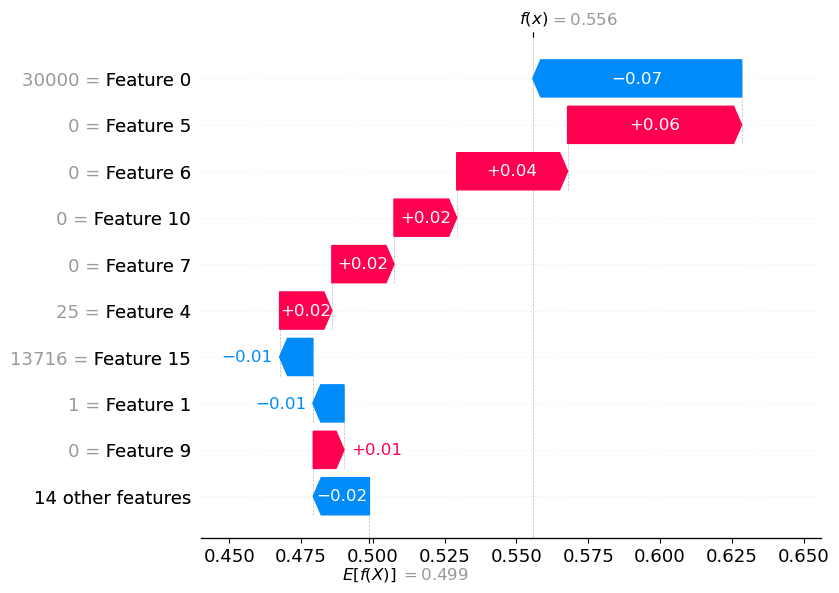

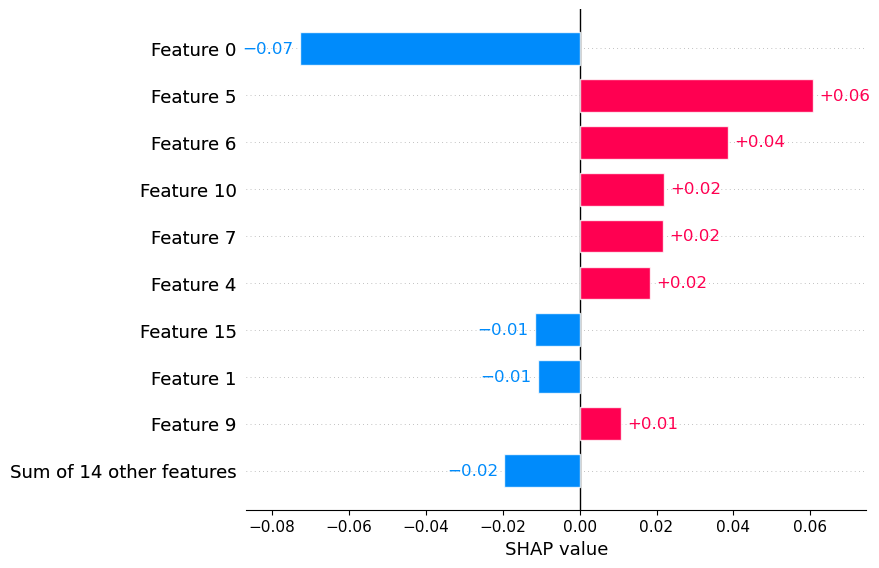

After seing this plot, I have concluded that the variable 'ID' should not be used therefore, all calculations must 
be remade
This is one of the thing why XAI is so important, to be able to see where our model is taking unwanted viases.
Another thing to look for is whether sex or age play a big role in the predicions

In [357]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=42)  
scaled_X_train=scaler.fit_transform(X_train)
scaled_X_test=scaler.transform(X_test)
unscaled_X_test = scaler.inverse_transform(scaled_X_test)

whaterfall_plot(shap_values,X_test,0)
print("")
print("""
After seing this plot, I have concluded that the variable 'ID' should not be used therefore, all calculations must be remade
This is one of the thing why XAI is so important, to be able to see where our model is taking unwanted viases.
Another thing to look for is whether sex or age play a big role in the predicions
""")

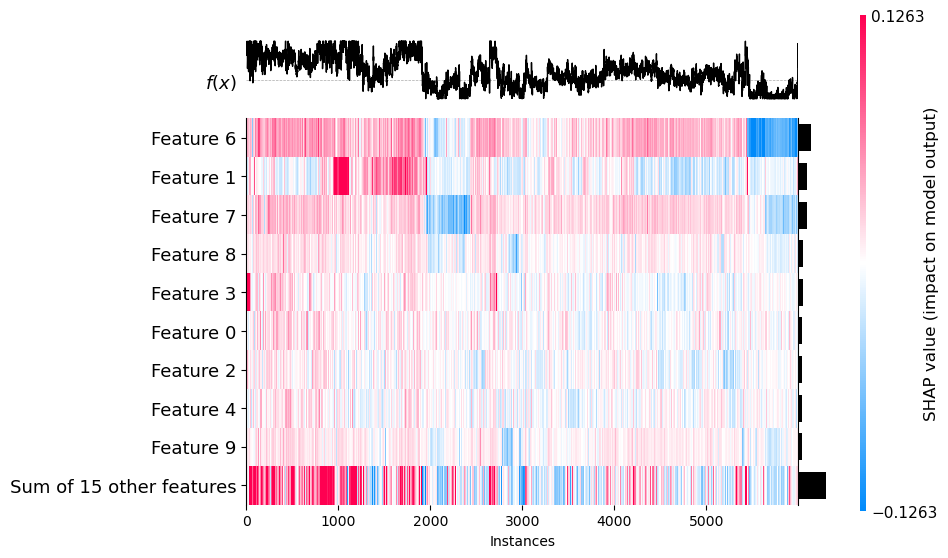

In [325]:
shap.plots.heatmap(shap_values[:, :, 0])

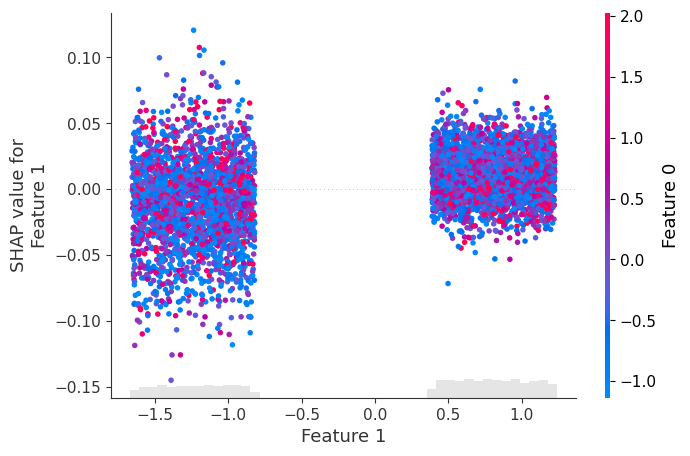

In [359]:
#shap_values[:,:,0]
shap.plots.scatter(shap_values[:,1,0],color = shap_values[:,0,0])

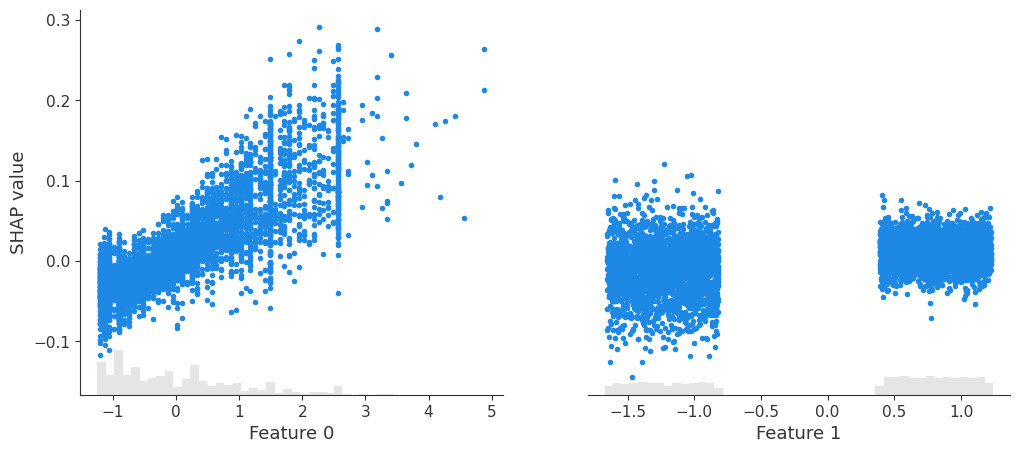

In [360]:
shap.plots.scatter(shap_values[:, shap_values.abs.mean(0).argsort[-1],0])

In [361]:
 shap_values.abs.mean(0).argsort[-1]

.values =
array([0, 1], dtype=int64)

.base_values =
array([0.49881638, 0.50118362])

.data =
1

#### LIME


<table style="width: 100%;">
  <tr>
      <td style="text-align: left;"><td>
    <td style="text-align: right;"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Logo_Universitat_de_Barcelona.png" alt="University of Barcelona Logo" width="200" /></td>
  </tr>
</table>